# **Валидация оценки позы на видео**

## Загрузка инструментов

In [453]:
import os
import re
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from pose_estimation_modul import frames2keypoints
from pose_estimation_modul import get_vectors, limbs, show_vectors
from io import BytesIO
from scipy.optimize import minimize

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Для начала нужно бы найти подходящее видео: в идеале это два ролика, на которых люди выполняют одинаковые движения. В TikTok-е как раз достаточно такого материала. Как только нам удастся обнаружить что-нибудь подходящее, мы можем легко это скачать, например, с помощью сервиса [tiktokdownloader.com](https://tiktokdownloader.com/).

И мне удалось найти [кое-что вполне подходящее](https://www.tiktok.com/@dubkovapo/video/7030435000029875458?is_from_webapp=1&sender_device=pc&web_id=7426412570464224774)! gif-ка на основе набора из каждого третьего кадра ролика (подраздел "Создание GIF"):

![Animated GIF](mediafiles/TikTok_Dance_GIF.gif)

Получилось сократить время tiktok-сёрфинга: (1) девушки танцуют один и тот же танец; (2) мы можем легко разделить кадры одного и того же ролика на два; (3) нам не требуется сводить кадры двух роликов.

Хотя мы здесь можем заметить некоторый рассинхрон ближе к концу, что может ухудшить метрики сходства, ничто нам не мешает предусмотреть специальное решение для этого случая: усреднить вектора за несколько кадров или что-то т.п.

## Загрузка ролика

Выведем основную информацию по видеофайлу.

In [4]:
videoFile = "mediafiles/TikTok_Dance.mp4"
cap = cv2.VideoCapture(videoFile)   # загрузка видео 

# Проверяем, удалось ли открыть видео
if not cap.isOpened():
    print("Ошибка: Не удалось открыть видео.")
else:
    # Получаем количество кадров в секунду
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print(f"Количество кадров в секунду: {fps}")

    # Получаем общее количество кадров
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Общее количество кадров: {total_frames}")

    # Получаем ширину и высоту видео
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f"Ширина видео: {width} пикселей")
    print(f"Высота видео: {height} пикселей")

# Освобождаем объект VideoCapture
cap.release()

Количество кадров в секунду: 30
Общее количество кадров: 366
Ширина видео: 576 пикселей
Высота видео: 1024 пикселей


## Извлечение кадров

In [5]:
# Создадим папку для кадров, если таковой ещё не было
frame_folder = "frames"
if not os.path.exists(frame_folder):
    os.makedirs(frame_folder)

# Открываем видеофайл
cap = cv2.VideoCapture(videoFile)

# Проверяем, удалось ли открыть видео
if not cap.isOpened():
    print("Ошибка: Не удалось открыть видео.")
else:
    frame_count = 0
    while True:
        ret, frame = cap.read()  # Читаем кадр 
        if not ret:
            break  # Если кадры закончились, выходим из цикла # Сохраняем кадр в файл
        frame_filename = os.path.join(frame_folder, f'frame_{frame_count:04d}.jpg')
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    print(f"Извлечено {frame_count} кадров.")

# Освобождаем объект VideoCapture
cap.release()

Извлечено 366 кадров.


Посмотрим на случайный кадр.

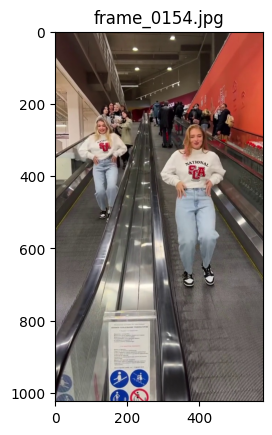

In [6]:
random_frame_name = np.random.choice(os.listdir('frames'))
path2folder = os.getcwd() + '\\' + 'frames' + '\\'
random_frame = plt.imread(path2folder + random_frame_name)
plt.title(random_frame_name)
plt.imshow(random_frame);

Перед нами стоит сложная задача: разделить кадры вертикально пополам; пропустить через модель оба набора кадров; произвести прокрустово наложение векторов; и посчитать метрики сходства.

Задача осложняется тем, что на кадрах имеются другие люди, а интересующие нас девушки танцуют на разных постепенно меняющихся местами планах.

## Создание GIF

In [7]:
# Список кадров
frame_names = [f for f in os.listdir(path2folder) if f.endswith(('jpg'))]

In [8]:
# Функция для извлечения числовой части из имени файла
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(0)) if match else 0

# Сортировка списка файлов
sorted_frame_names = sorted(frame_names, key=extract_number)

# Загрузка кадров и изменение их размера
max_width = int(width*0.5)
max_height = int(height*0.5)
images = []

for frame_name in sorted_frame_names[::3]:
    img = Image.open(os.path.join(frame_folder, frame_name))
    img.thumbnail((max_width, max_height), Image.LANCZOS)  # Изменяем размер
    img = img.convert('P', palette=Image.ADAPTIVE, colors=256)  # Уменьшаем количество цветов
    images.append(img)

# Создание и сохранение GIF
output_path = 'mediafiles/TikTok_Dance_GIF.gif'
images[0].save(
    output_path, save_all=True, append_images=images[1:],
    duration=3, loop=0, optimize=True
    )
print(f'GIF создан и сохранен как {output_path}')

GIF создан и сохранен как mediafiles/TikTok_Dance_GIF.gif


## Нарезка кадров

In [9]:
# Создадим папки для половинок кадров, если они ещё не были созданы
frames_right_halves_folder = "right_halves"
frames_left_halves_folder = "left_halves"
if not os.path.exists(frames_right_halves_folder):
    os.makedirs(frames_right_halves_folder)
if not os.path.exists(frames_left_halves_folder):
    os.makedirs(frames_left_halves_folder)

# Предположим, что frame_names и path2folder уже определены
for frame_name in tqdm(frame_names):
    # Открываем изображение
    image_path = os.path.join(path2folder, frame_name)
    image = Image.open(image_path)

    # Получаем размеры изображения
    width, height = image.size # Разделяем изображение на две части
    left_part = image.crop((0, 0, width // 2, height))  # Левая половина
    right_part = image.crop((width // 2, 0, width, height))  # Правая половина

    # Сохраняем левые и правые половины в соответствующие папки
    left_part_name = f"left_{frame_name.split('_')[1]}"  # Имя для левой половины 
    right_part_name = f"right_{frame_name.split('_')[1]}"  # Имя для правой половины

    left_part.save(os.path.join(frames_left_halves_folder, left_part_name))
    right_part.save(os.path.join(frames_right_halves_folder, right_part_name))


100%|██████████| 366/366 [00:02<00:00, 123.98it/s]


Выведем половинки случайного кадра.

In [10]:
# Получаем список файлов в папках
left_half_files = os.listdir(frames_left_halves_folder)
right_half_files = os.listdir(frames_right_halves_folder)

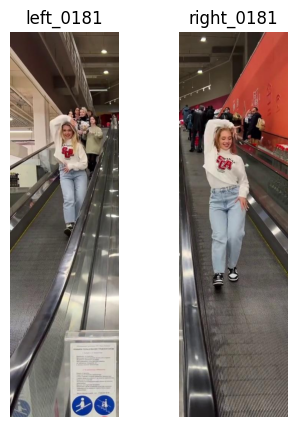

In [14]:
# Загружаем случайный половинки случайного кадра
random_idx = np.random.randint(len(left_half_files))
left_part_path = os.path.join(frames_left_halves_folder, left_half_files[random_idx])
right_part_path = os.path.join(frames_right_halves_folder, right_half_files[random_idx])
left_part_name = left_half_files[random_idx].split('.')[0]
right_part_name = right_half_files[random_idx].split('.')[0]
left_part = Image.open(left_part_path)
right_part = Image.open(right_part_path)

# Отображаем обе части
plt.figure(figsize=(4, 5))

plt.subplot(1, 2, 1)
plt.imshow(left_part)
plt.title(left_part_name)
plt.axis('off')  # Отключаем оси

plt.subplot(1, 2, 2)
plt.imshow(right_part)
plt.title(right_part_name)
plt.axis('off')  # Отключаем оси

plt.show()

## Генерация ключевых точек

Т.к. в начале ролика мы видим только одну из девушек, то нам нужно выбрать кадр, начиная с которого мы можем приступать к анализу поз.

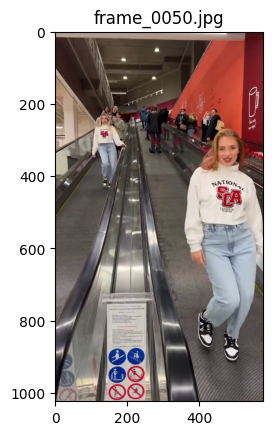

In [67]:
IDX = 50
relevant_frame_names = frame_names[IDX:]
path2startFrame = path2folder + frame_names[IDX]
start_frame = plt.imread(path2startFrame)
plt.title(frame_names[IDX])
plt.imshow(start_frame);

Я выбрал 50-й кадр для начала анализа.

Пропустим кадры через модель и получим предсказания ключевых точек и метрики схожести.

In [12]:
outputs = frames2keypoints(
    frames_right_halves_folder, 
    frames_left_halves_folder, 
    start_IDX=50
    )

Processing frames: 100%|██████████| 316/316 [13:58<00:00,  2.65s/it]


Отобразим случайную пару для контроля результата.

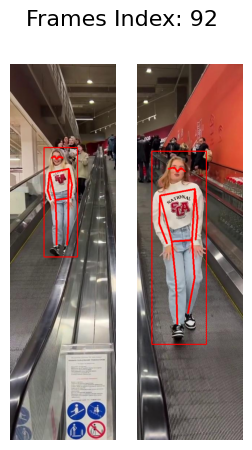

In [17]:
random_idx = np.random.randint(len(outputs))
result_img_with_skeleton1, result_img_with_skeleton2 = outputs[random_idx][:2]
# Отображаем результат
fig, ax = plt.subplots(1, 2, figsize=(3, 5))
# Отрисовка
ax[0].imshow(result_img_with_skeleton2)
ax[1].imshow(result_img_with_skeleton1)
ax[0].axis('off')
ax[1].axis('off')
# Установка общего заголовка с индексом
fig.suptitle(f'Frames Index: {random_idx}', fontsize=16)
plt.show()

## Расчёт метрик

Получим динамику метрик схожести.

In [16]:
mean_cossims = []
cossims_lists = []
weighted_sims = []
mean_sims = []

for i in range(len(outputs)):
    mean_cossims.append(outputs[i][2])
    cossims_lists.append(outputs[i][3])
    weighted_sims.append(outputs[i][4])
    mean_sims.append(outputs[i][5])

Отрисуем метрики.

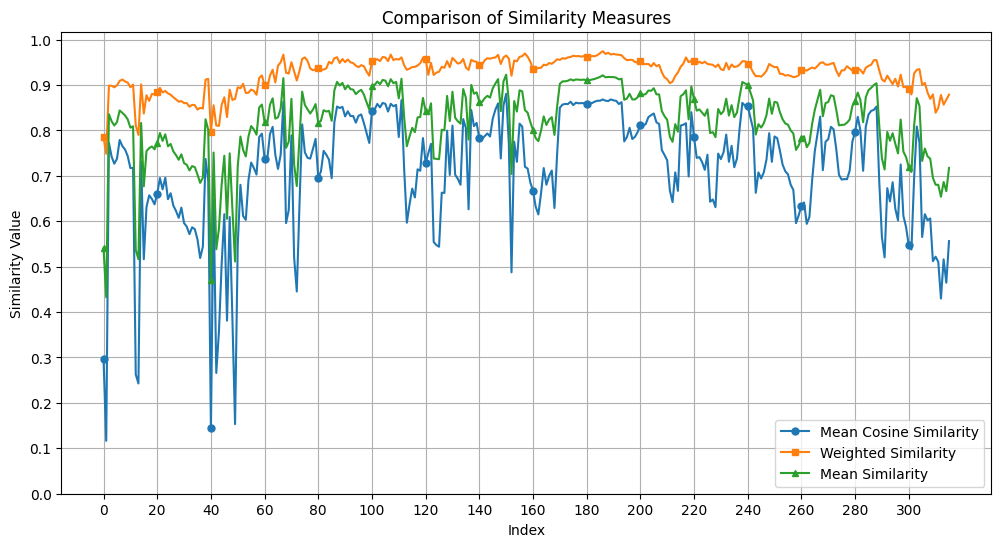

In [17]:
# Создание графика
plt.figure(figsize=(12, 6))

# Определяем шаг для маркеров
tick_interval = 20  # Интервал делений по оси X

# Создаем массив индексов, где будут отображаться маркеры
markevery_indices = np.arange(0, len(mean_cossims), tick_interval)

# Добавление линий для каждого списка с маркерами на нужных индексах
plt.plot(mean_cossims, label='Mean Cosine Similarity',
         marker='o', markersize=5, markevery=markevery_indices)
plt.plot(weighted_sims, label='Weighted Similarity',
         marker='s', markersize=5, markevery=markevery_indices)
plt.plot(mean_sims, label='Mean Similarity', marker='^',
         markersize=5, markevery=markevery_indices)

# Настройка графика
plt.title('Comparison of Similarity Measures')
plt.xlabel('Index')
plt.ylabel('Similarity Value')

# Настройка меток по оси X (каждые 20 значений)
plt.xticks(
    ticks=np.arange(0, 316, step=20),
    labels=np.arange(0, 316, step=20)
    )

# Настройка делений по оси Y (от 0 до 1 с шагом 0.1)
plt.yticks(np.arange(0, 1.1, step=0.1))

plt.legend()  # Отображение легенды
plt.grid()  # Включение сетки

# Показать график
plt.show()

In [18]:
print('Вторично усредненные метрики за весь ролик:')
print(f'Средняя косинусная схожесть:\t{np.mean(mean_cossims):.4f}')
print(f'Средневзвешенная схожесть:\t{np.mean(weighted_sims):.4f}')
print(f'Средняя схожесть:\t\t{np.mean(mean_sims):.4f}')

Вторично усредненные метрики за весь ролик:
Средняя косинусная схожесть:	0.7163
Средневзвешенная схожесть:	0.9263
Средняя схожесть:		0.8213


Мы можем также посмотреть на динамику косинусной схожести каждого из векторов.

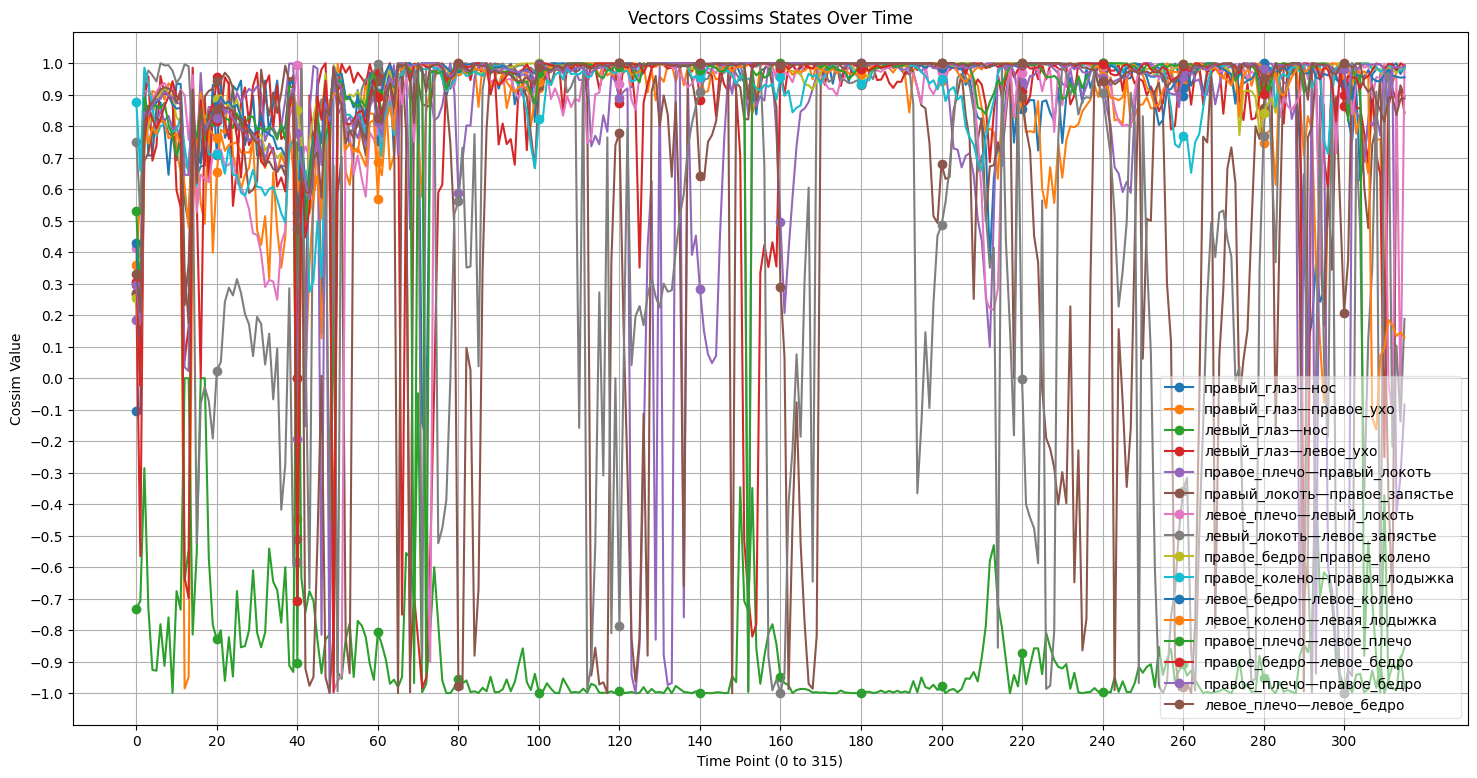

In [19]:
# Преобразуем список списков в NumPy массив для удобства
cossims_array = np.array(cossims_lists)

# Список "имён векторов", составленных из конечных точек
vecs_names = [
    "правый_глаз—нос", "правый_глаз—правое_ухо",
    "левый_глаз—нос", "левый_глаз—левое_ухо",
    "правое_плечо—правый_локоть", "правый_локоть—правое_запястье",
    "левое_плечо—левый_локоть", "левый_локоть—левое_запястье",
    "правое_бедро—правое_колено", "правое_колено—правая_лодыжка",
    "левое_бедро—левое_колено", "левое_колено—левая_лодыжка",
    "правое_плечо—левое_плечо", "правое_бедро—левое_бедро",
    "правое_плечо—правое_бедро", "левое_плечо—левое_бедро"
]

# Установка числа датчиков
num_sensors = cossims_array.shape[1]  # 16 точек
time_points = cossims_array.shape[0]  # Количество временных точек

# Создание графика
plt.figure(figsize=(18, 9))

# Определяем шаг для маркеров
tick_interval = 20  # Интервал делений по оси X

# Проходим по каждому датчику и отображаем его данные на графике
for sensor_idx in range(num_sensors):
    # Создаем список индексов, где будут отображаться маркеры
    markevery_indices = np.arange(0, time_points, tick_interval)
    plt.plot(
        cossims_array[:, sensor_idx], marker='o',
        markevery=markevery_indices,
        label=f'{vecs_names[sensor_idx]}'
        )

# Настройка графика
plt.title('Vectors Cossims States Over Time')
plt.xlabel('Time Point (0 to {})'.format(time_points - 1))
plt.ylabel('Cossim Value')
plt.xticks(
    ticks=np.arange(0, time_points + 1, 20),
    labels=np.arange(0, time_points + 1, 20)
    )  
plt.yticks(np.arange(-1, 1.1, step=0.1))
plt.legend(loc='lower right', framealpha=0.5)
plt.grid()
plt.show()

Как видим один из векторов с зелёным лейблом почти всегда имеет полностью обратную косинусную схожесть. Было бы здорово — узнать где именно совершается ошибка в движениях.

In [20]:
# Создание словаря с ключами из vecs_names и пустыми списками
cossims_dict = {name: [] for name in vecs_names}

# Заполнение словаря значениями из cossims_lists
for cossims in cossims_lists:
    for idx, value in enumerate(cossims):
        cossims_dict[vecs_names[idx]].append(value)

# Выведем сводку по метрикам каждого вектора
pd.DataFrame(cossims_dict).describe().T

,count,mean,std,min,25%,50%,75%,max
правый_глаз—нос,316.0,0.889668,0.197167,-0.196116,0.873654,0.968210,0.995246,1.000000
правый_глаз—правое_ухо,316.0,0.843376,0.262129,-0.984784,0.795621,0.938343,0.990019,1.000000
левый_глаз—нос,316.0,-0.887883,0.204279,-1.000000,-0.995893,-0.964631,-0.857493,0.737154
левый_глаз—левое_ухо,316.0,0.810681,0.393937,-0.983870,0.858928,0.948683,0.986529,1.000000
правое_плечо—правый_локоть,316.0,0.737588,0.469660,-1.000000,0.778108,0.918253,0.984632,0.999996
правый_локоть—правое_запястье,316.0,0.471264,0.649394,-0.999972,0.200689,0.782697,0.945183,1.000000
левое_плечо—левый_локоть,316.0,0.850943,0.285678,-0.993413,0.861170,0.952227,0.988806,1.000000
левый_локоть—левое_запястье,316.0,0.391776,0.648640,-1.000000,-0.003355,0.661960,0.959824,0.999980
правое_бедро—правое_колено,316.0,0.951022,0.102007,0.013971,0.959413,0.993287,0.998745,1.000000
правое_колено—правая_лодыжка,316.0,0.904299,0.132900,0.273567,0.860031,0.963547,0.991794,0.999999


Нерегулярные отрицательные значения встречаются почти у всех векторов. Но стабильно в области отрицательных значений пребывает только косинусная схожесть по векторам "левый_глаз—нос", что нектричино. Похоже, мы можем утверждать, что девушки синхронно танцуют один и тот же танец :)

## Финальная визуализация

In [454]:
def compute_center_of_mass(points):
    return np.mean(points, axis=0)

def transform_points(A, angle, scale):
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle), np.cos(angle)]])
    return scale * (A @ R)

def objective_function(params, A, B):
    angle, scale = params
    A_transformed = transform_points(A, angle, scale)
    return np.sum(np.linalg.norm(A_transformed - B, axis=1)**2)

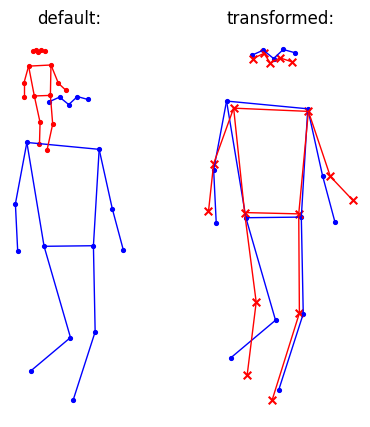

In [455]:
idx = 0
left_vectors = get_vectors(outputs[idx][7][0].numpy(), limbs)
A, B = outputs[idx][7][0][:, :2].numpy(), outputs[idx][6][0][:, :2].numpy()

# Центрирование
center_A = compute_center_of_mass(A)
center_B = compute_center_of_mass(B)

A_centered = A - center_A
B_centered = B - center_B

# Начальные параметры для оптимизации
initial_params = [0.0, 1.0]  # [angle, scale]

# Оптимизация
result = minimize(objective_function, initial_params, args=(A_centered, B_centered))

optimal_angle, optimal_scale = result.x

# Применяем найденные параметры
A_transformed = transform_points(A_centered, optimal_angle, optimal_scale) + center_B


transformed_left_vectors = get_vectors(
    A_transformed, limbs
    )
right_vectors = get_vectors(outputs[idx][6][0].numpy(), limbs)

# Визуализация исходных и преобразованных данных
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

show_vectors(right_vectors, ax[0])
show_vectors(left_vectors, ax[0], color='r')

show_vectors(right_vectors, ax[1])
show_vectors(transformed_left_vectors, ax[1],
             color='r', marker='x')

# Настройки графика
ax[0].set_title('default:')
ax[1].set_title('transformed:')
ax[0].axis('off')
ax[1].axis('off')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
plt.show()

In [479]:
def outputs2gif2(
    st_frames_folder, tch_frames_folder, outputs,
    st_files, tch_files,
    gif_filename='dancing.gif', figsize=(7, 5)
    ):
    mean_cossims = []
    cossims_lists = []
    weighted_sims = []
    mean_sims = []
    kpts1, kpts2 = [], []

    for i in range(len(outputs)):
        mean_cossims.append(outputs[i][2])
        cossims_lists.append(outputs[i][3])
        weighted_sims.append(outputs[i][4])
        mean_sims.append(outputs[i][5])
        kpts1.append(outputs[i][6])
        kpts2.append(outputs[i][7])
        
    images = []

    for i in tqdm(range(0, len(outputs), 3), desc="Processing frames"):
        # Получаем метрики
        mean_cossim = mean_cossims[i]
        weighted_sim = weighted_sims[i]
        mean_sim = mean_sims[i]
        A, B = kpts2[i][0][:, :2].numpy(), kpts1[i][0][:, :2].numpy()

        # Центрирование
        center_A = compute_center_of_mass(A)
        center_B = compute_center_of_mass(B)

        A_centered = A - center_A
        B_centered = B - center_B

        # Начальные параметры для оптимизации
        initial_params = [0.0, 1.0]  # [angle, scale]

        # Оптимизация
        result = minimize(objective_function, initial_params, args=(A_centered, B_centered))

        optimal_angle, optimal_scale = result.x

        # Применяем найденные параметры
        A_transformed = transform_points(A_centered, optimal_angle, optimal_scale) + center_B

        tf_st_vectors = get_vectors(
            A_transformed, limbs
            )
        tch_vectors = get_vectors(kpts1[i][0].numpy(), limbs)
        
        # Создаем фигуру и задаем размеры
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1])

        # Визуализация левого полукадра 
        left_part_path = os.path.join(st_frames_folder, st_files[i])
        left_half_image = plt.imread(left_part_path)
        axs0 = fig.add_subplot(gs[0])
        axs0.imshow(left_half_image)
        axs0.axis('off')

        # Визуализация векторов для левого танцора
        axs1 = fig.add_subplot(gs[1])
        show_vectors(np.array(tf_st_vectors), ax=axs1)
        axs1.axis('off')
        axs1.invert_yaxis()

        # Визуализация векторов для правого танцора
        axs2 = fig.add_subplot(gs[2])
        show_vectors(np.array(tch_vectors), ax=axs2, color='r')
        axs2.axis('off')
        axs2.invert_yaxis()

        # Визуализация правого полукадра 
        right_part_path = os.path.join(tch_frames_folder, tch_files[i])
        right_half_image = plt.imread(right_part_path)
        axs3 = fig.add_subplot(gs[3])
        axs3.imshow(right_half_image)
        axs3.axis('off')

        # Добавление текста с ID кадра и метрикой косинусной схожести
        plt.figtext(0.5, 0.95, f'Frame ID: {i}', ha='center', fontsize=12)
        plt.figtext(0.5, 0.9, f'CosSim: {mean_cossim:.4f}', ha='center', fontsize=12)
        plt.figtext(0.5, 0.85, f'WeightSim: {weighted_sim:.4f}', ha='center', fontsize=12)
        plt.figtext(0.5, 0.80, f'MeanSim: {mean_sim:.4f}', ha='center', fontsize=12)

        plt.subplots_adjust(wspace=0.8)
        plt.tight_layout()

        # Сохраняем изображение в BytesIO 
        img_byte_arr = BytesIO()
        # Сохраняем в формате PNG
        plt.savefig(img_byte_arr, format='png', bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)  # Закрываем фигуру
        img_byte_arr.seek(0)  # Перемещаем указатель в начало

        # Открываем изображение из BytesIO и добавляем его в список
        images.append(Image.open(img_byte_arr))

    # Создаем GIF из списка изображений
    images[0].save(gif_filename, save_all=True, append_images=images[1:], loop=0, duration=3)

    print(f'GIF saved as {gif_filename}')

In [480]:
outputs2gif2(
    frames_left_halves_folder, frames_right_halves_folder, outputs,
    left_half_files[IDX:], right_half_files[IDX:],
    gif_filename='mediafiles/dancing.gif', figsize=(7, 5)
    )

Processing frames: 100%|██████████| 106/106 [00:32<00:00,  3.23it/s]


GIF saved as mediafiles/dancing.gif


![Animated GIF](mediafiles/dancing_keypointrcnn.gif)